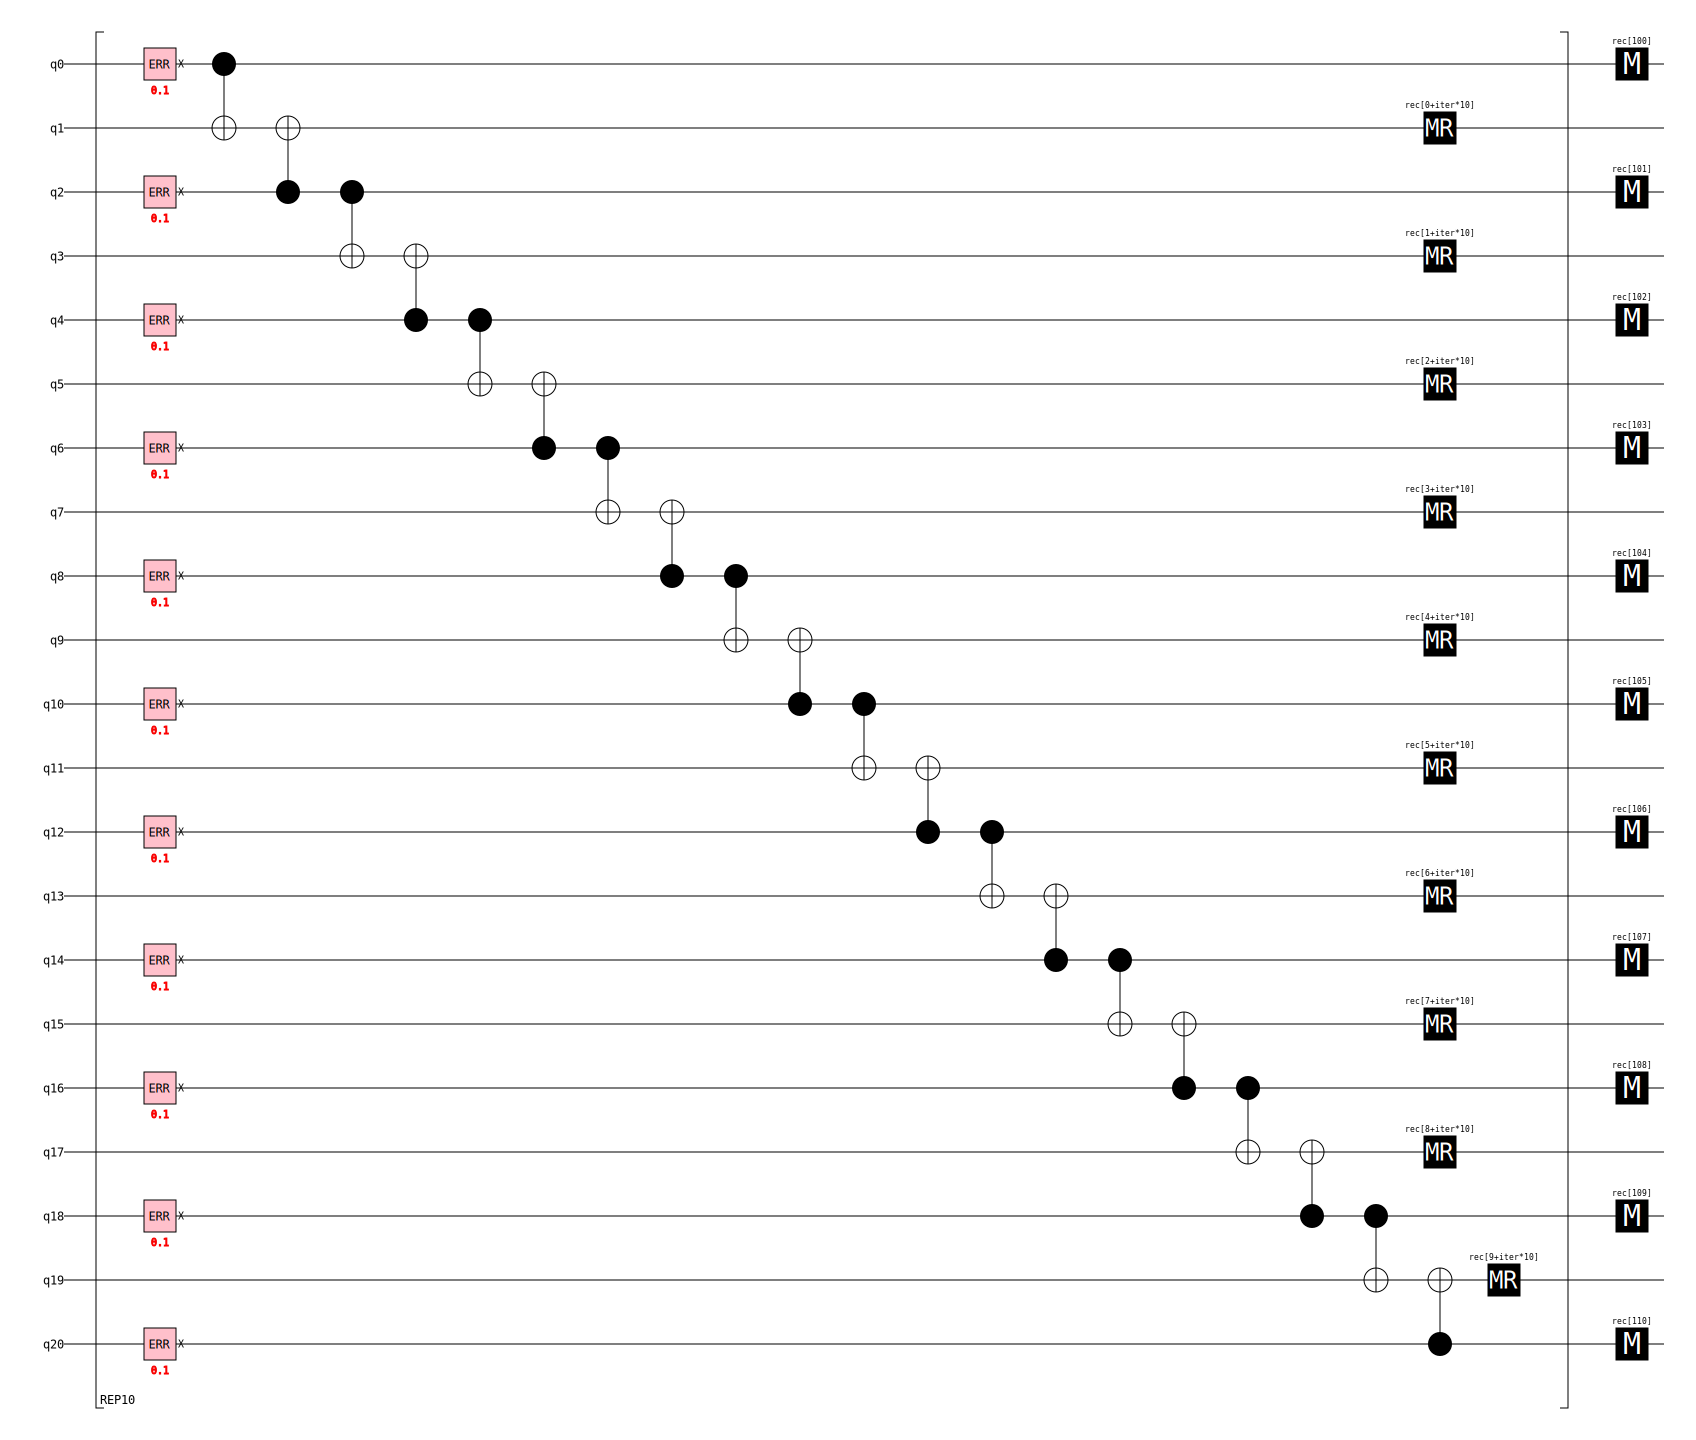

In [538]:
import stim
import numpy as np
from IPython.display import SVG

# ---------- Helpers ----------
def bits_to_str(x, one="1", zero="_"):
    # x can be np.bool_, np.uint8, or Python bool/int
    return "".join(one if int(b) else zero for b in x)

def decode_min_weight_from_syndrome(s: np.ndarray) -> np.ndarray:
    """
    s: shape (d,), dtype bool/uint8. Returns ê of shape (n=d+1,), dtype uint8.
    Uses ML for i.i.d. X noise p<1/2: choose the lower-weight of the two solutions.
    """
    s = s.astype(np.uint8, copy=False)
    # e0[0]=0; e0[i]= XOR_{k=0}^{i-1} s[k]  -> prefix XOR == cumsum mod 2
    e0 = np.empty(s.size + 1, dtype=np.uint8)
    e0[0] = 0
    e0[1:] = np.cumsum(s, dtype=np.uint32) % 2
    w0 = int(e0.sum())
    if 2 * w0 <= e0.size:
        return e0
    else:
        return 1 - e0  # global complement

# ---------- Circuit ----------
def rep_code_with_final_data(distance: int, rounds: int, noise: float) -> stim.Circuit:
    circuit = stim.Circuit()
    qubits = range(2 * distance + 1)
    data = qubits[::2]   # n = distance + 1 data qubits
    meas = qubits[1::2]  # distance ancillas

    
    circuit.append_operation("X_ERROR", data, noise)
    for m in meas:
        circuit.append_operation("CNOT", [m - 1, m])
        circuit.append_operation("CNOT", [m + 1, m])
    circuit.append_operation("MR", meas)  # distance bits per round

    circuit = circuit * rounds  # repeat rounds times

    circuit.append_operation("M", data)       # final data readout (n bits)
    return circuit

# ---------- Run + Check ----------
def distance_d_repetition_code(distance: int, rounds: int, noise: float):
    circ = rep_code_with_final_data(distance, rounds, noise)
    rec = circ.compile_sampler().sample(1)[0]            # np.ndarray of bools, shape (rounds*distance + n,)
    d = distance
    n = d + 1

    # Split record
    syndromes = rec[: rounds * d].reshape(rounds, d)     # (rounds, distance)
    data_final = rec[rounds * d : ].astype(np.uint8)     # (n,)

    frame = np.zeros(n, dtype=np.uint8)
    prev  = np.zeros(n, dtype=np.uint8)
    prev_syndrome = np.zeros(d, dtype=np.uint8)
    for r in range(rounds):
        delta = decode_min_weight_from_syndrome(syndromes[r].astype(np.uint8) ^ prev_syndrome).astype(np.uint8)
        prev_syndrome = syndromes[r].astype(np.uint8)
        frame ^= delta

    corrected_data = data_final ^ frame


    # Majority vote (prep = |0>_L)
    raw_ones = int(data_final.sum())
    cor_ones = int(corrected_data.sum())
    raw_logical = 1 if raw_ones > n // 2 else 0
    cor_logical = 1 if cor_ones > n // 2 else 0
    logical_error = (cor_logical != 0)

    # Compact summary
    # print(f"rounds={rounds}, distance={distance}, n={n}, noise={noise}")
    # print("final data (raw):       ", bits_to_str(data_final))
    # print("final Pauli frame (X):  ", bits_to_str(frame, one='X', zero='_'))
    # print("final data (corrected): ", bits_to_str(corrected_data))
    # print(f"raw logical = {raw_logical}, corrected logical = {cor_logical}")
    # print("LOGICAL ERROR (after correction)?", logical_error)

    return {
        "circuit": circ,
        "syndromes": syndromes,          # (rounds, distance) bool
        "frame": frame,                  # (n,) uint8
        "data_final": data_final,        # (n,) uint8
        "corrected_data": corrected_data,# (n,) uint8
        "raw_logical": raw_logical,
        "corrected_logical": cor_logical,
        "logical_error": logical_error,
        "SVG":  SVG(str(circ.diagram("timeline")))
    }

# ---------- Example ----------
out = distance_d_repetition_code(distance=10, rounds=10, noise=0.1)
out["SVG"]  # Display the circuit


In [551]:
def collect_stats(distance: int, rounds: int, noise: float, trials: int = 1000):
    raw = []
    cor = []
    fails = 0
    out_examples = None

    for t in range(trials):
        out = distance_d_repetition_code(distance, rounds, noise)
        raw.append(out["raw_logical"])
        cor.append(out["corrected_logical"])
        fails += int(out["logical_error"])
        # keep one example dict to inspect later
        if out_examples is None and out["logical_error"]:
            out_examples = out

    raw_rate = float(np.mean(raw))
    cor_rate = float(np.mean(cor))

    print(f"[distance={distance}, rounds={rounds}, noise={noise}, trials={trials}]")
    print(f"Raw logical error rate:       {raw_rate:.6f}")
    print(f"Corrected logical error rate: {cor_rate:.6f}")
    print(f"Failures counted:             {fails}/{trials}")

    return {
        "raw_rate": raw_rate,
        "corrected_rate": cor_rate,
        "fail_count": fails,
        "trials": trials,
        "example": out_examples  # may be None if no failures
    }

# Example:
stats = collect_stats(distance=15, rounds=100, noise=0.05, trials=10000)

[distance=15, rounds=100, noise=0.05, trials=10000]
Raw logical error rate:       0.403000
Corrected logical error rate: 0.000000
Failures counted:             0/10000


Raw logical error rate:        0.403
Corrected logical error rate:  0.0


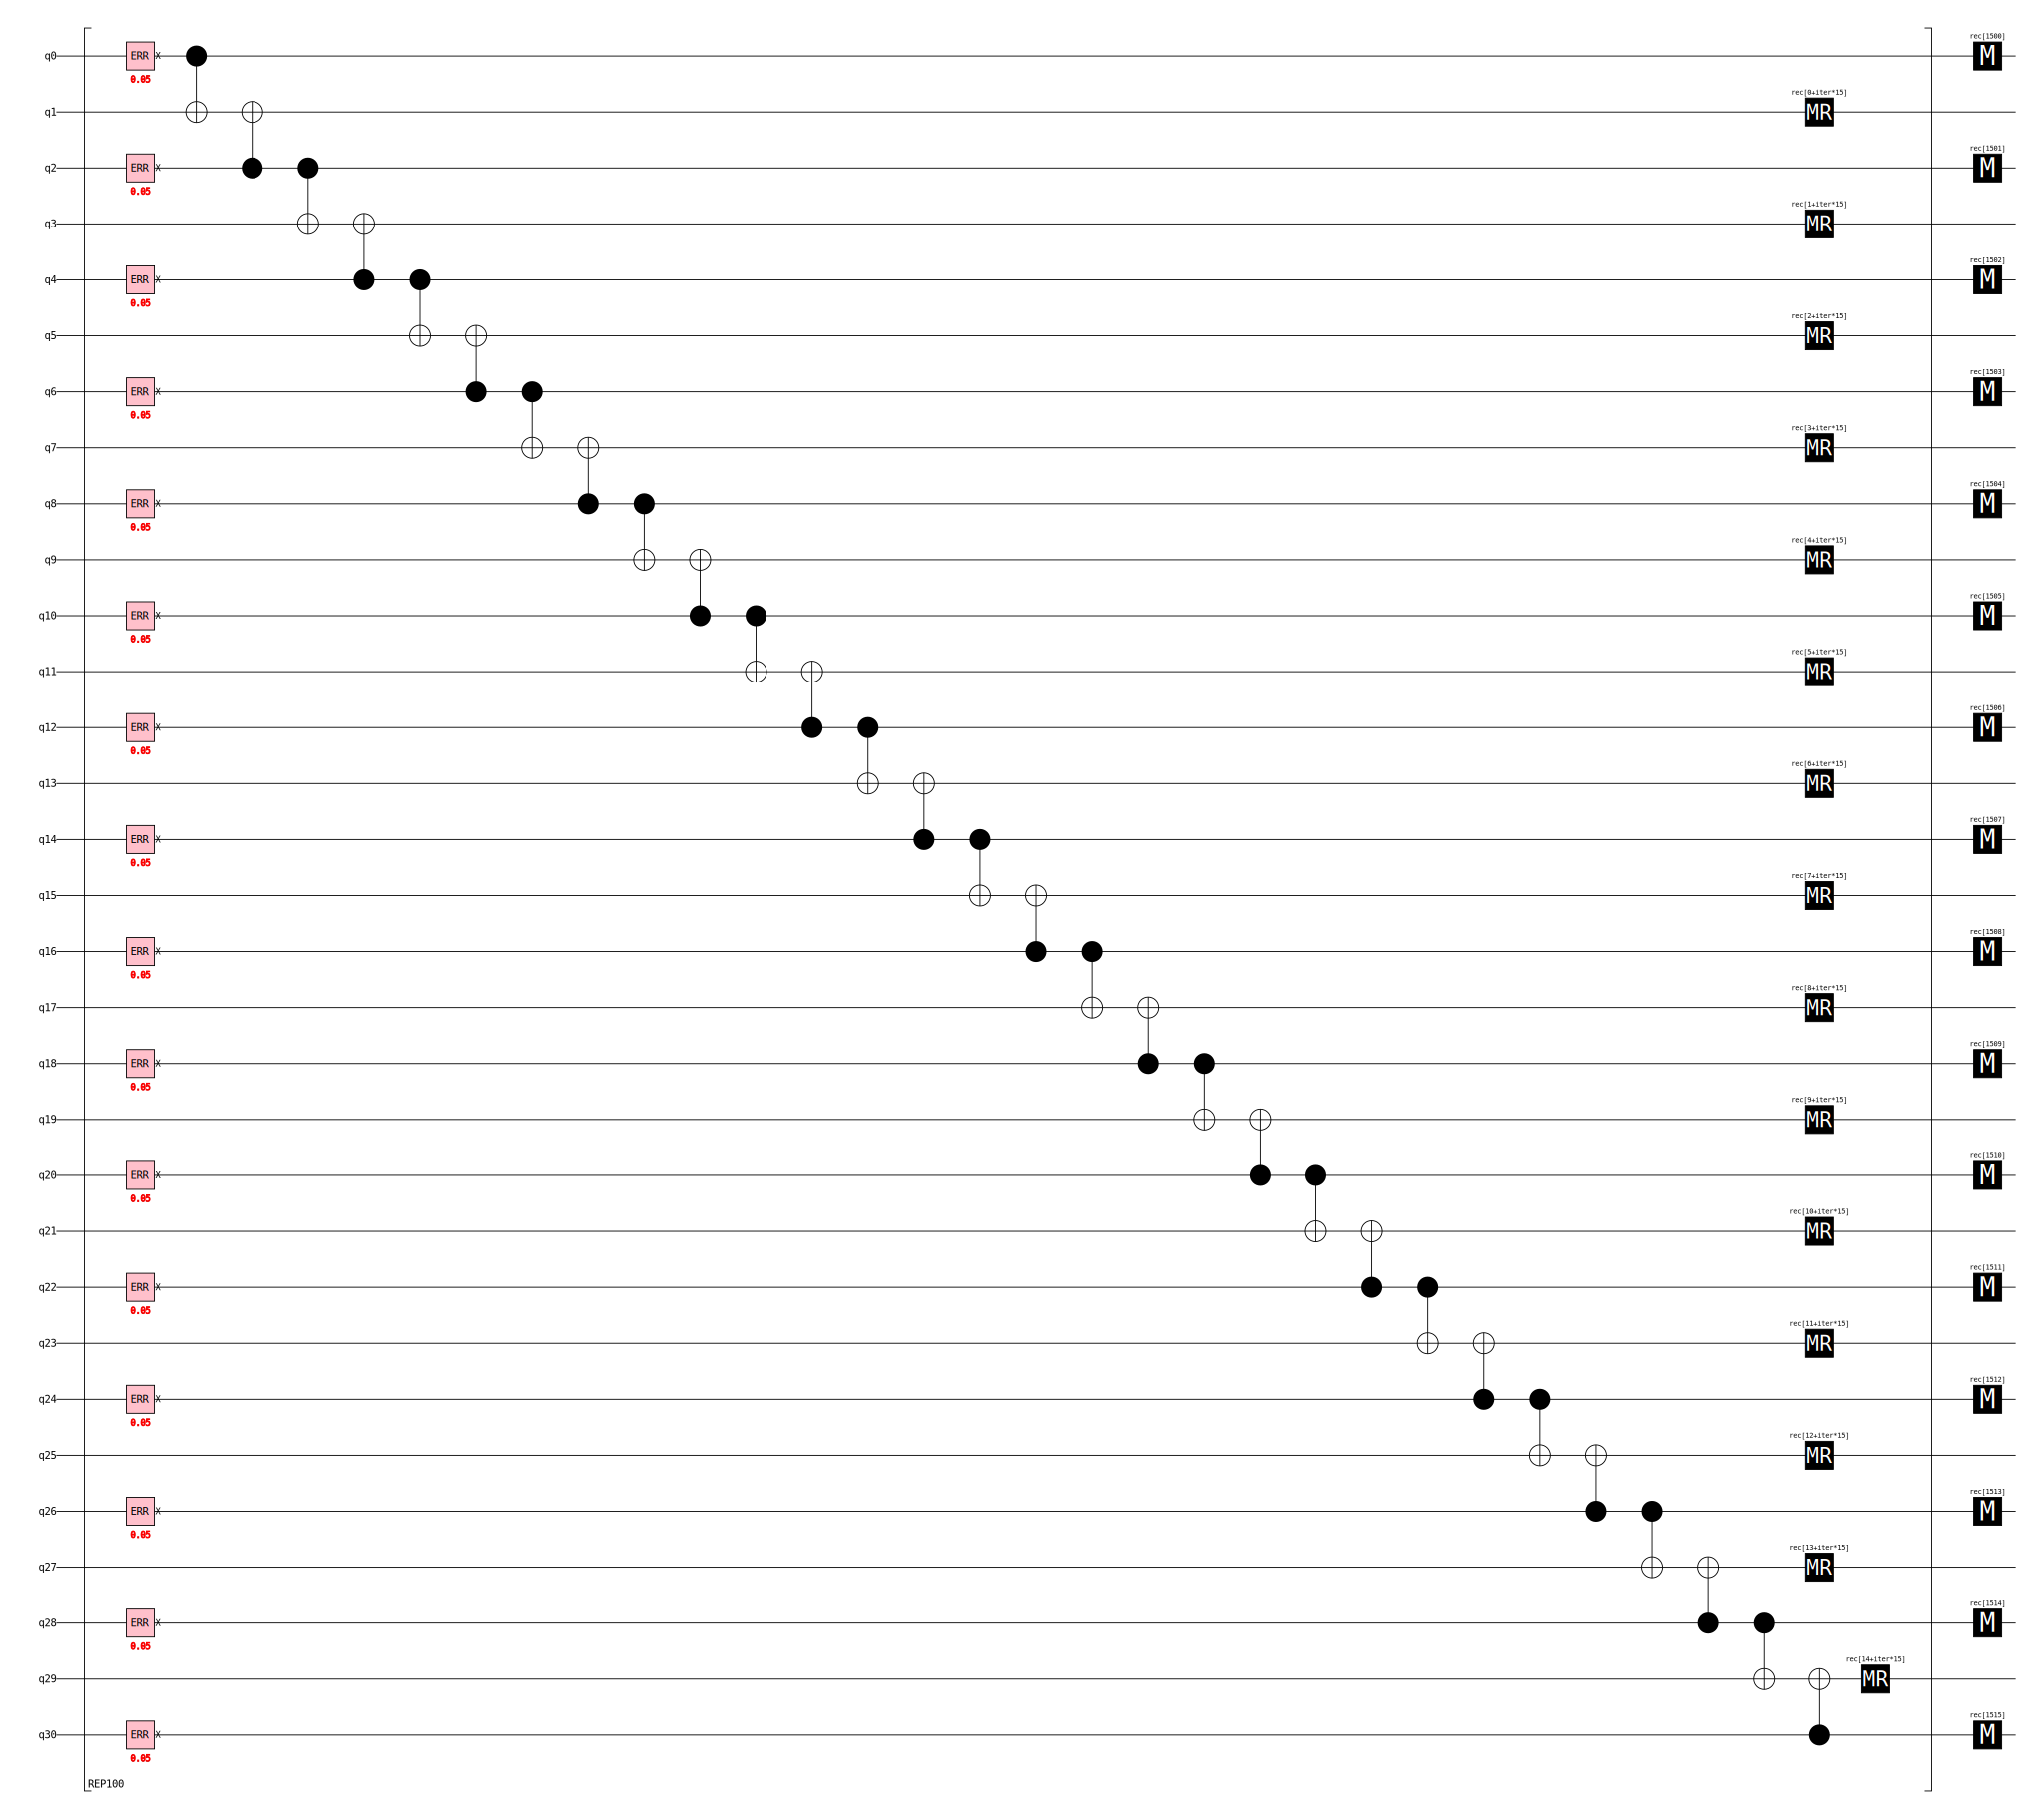

In [553]:
import stim
import numpy as np
from IPython.display import SVG

# ---------- Helpers ----------
def bits_to_str(x, one="1", zero="_"):
    return "".join(one if int(b) else zero for b in x)

def decode_min_weight_from_syndrome(s: np.ndarray) -> np.ndarray:
    """
    s: shape (d,), dtype bool/uint8. Returns ê of shape (n=d+1,), dtype uint8.
    Uses ML for i.i.d. X noise p<1/2: choose the lower-weight of the two solutions.
    """
    s = s.astype(np.uint8, copy=False)
    e0 = np.empty(s.size + 1, dtype=np.uint8)
    e0[0] = 0
    e0[1:] = np.cumsum(s, dtype=np.uint32) % 2
    w0 = int(e0.sum())
    return e0 if 2 * w0 <= e0.size else (1 - e0)

# ---------- Circuit ----------
def rep_code_with_final_data(distance: int, rounds: int, noise: float) -> stim.Circuit:
    circuit = stim.Circuit()
    qubits = range(2 * distance + 1)
    data = qubits[::2]   # n = distance + 1 data qubits
    meas = qubits[1::2]  # distance ancillas

    circuit.append_operation("X_ERROR", data, noise)
    for m in meas:
        circuit.append_operation("CNOT", [m - 1, m])
        circuit.append_operation("CNOT", [m + 1, m])
    circuit.append_operation("MR", meas)  # distance bits per round

    circuit = circuit * rounds  # repeat rounds times
    circuit.append_operation("M", data)   # final data readout (n bits)
    return circuit

# ---------- Per-record processing ----------
def _process_one_record(rec: np.ndarray, d: int, rounds: int):
    """Return (raw_logical, corrected_logical, logical_error_bool, frame, data_final, corrected_data)."""
    n = d + 1
    syndromes = rec[: rounds * d].reshape(rounds, d)     # (rounds, d) bool
    data_final = rec[rounds * d : ].astype(np.uint8)     # (n,)

    frame = np.zeros(n, dtype=np.uint8)
    prev_syndrome = np.zeros(d, dtype=np.uint8)
    for r in range(rounds):
        cur = syndromes[r].astype(np.uint8)
        delta = decode_min_weight_from_syndrome(cur ^ prev_syndrome).astype(np.uint8)
        prev_syndrome = cur
        frame ^= delta

    corrected_data = data_final ^ frame

    # Majority vote (target state |0>_L -> expect logical 0)
    raw_ones = int(data_final.sum())
    cor_ones = int(corrected_data.sum())
    raw_logical = 1 if raw_ones > n // 2 else 0
    corrected_logical = 1 if cor_ones > n // 2 else 0
    logical_error = (corrected_logical != 0)

    return raw_logical, corrected_logical, logical_error, frame, data_final, corrected_data

# ---------- Run + Aggregate ----------
def distance_d_repetition_code(distance: int, rounds: int, noise: float, shots: int = 1, keep_details: bool = False):
    """
    Runs the distance-d repetition code for `shots` samples.
    Returns logical error *rates* plus optional per-shot details.
    """
    circ = rep_code_with_final_data(distance, rounds, noise)
    sampler = circ.compile_sampler()
    recs = sampler.sample(shots)  # shape (shots, rounds*d + n)

    d = distance
    n = d + 1

    raw_logicals = np.empty(shots, dtype=np.uint8)
    cor_logicals = np.empty(shots, dtype=np.uint8)
    logical_errors = np.empty(shots, dtype=np.uint8)

    details = [] if keep_details else None

    for i in range(shots):
        rl, cl, le, frame, data_final, corrected_data = _process_one_record(recs[i], d, rounds)
        raw_logicals[i] = rl
        cor_logicals[i] = cl
        logical_errors[i] = le
        if keep_details:
            syndromes = recs[i][: rounds * d].reshape(rounds, d)
            details.append({
                "syndromes": syndromes,
                "frame": frame,
                "data_final": data_final,
                "corrected_data": corrected_data,
                "raw_logical": int(rl),
                "corrected_logical": int(cl),
                "logical_error": bool(le),
            })

    # Rates: probability logical is 1 when target is |0>_L
    raw_logical_error_rate = float(raw_logicals.mean())
    corrected_logical_error_rate = float(logical_errors.mean())

    out = {
        "circuit": circ,
        "shots": shots,
        "distance": distance,
        "rounds": rounds,
        "noise": noise,
        "raw_logical_error_rate": raw_logical_error_rate,
        "corrected_logical_error_rate": corrected_logical_error_rate,
        "SVG": SVG(str(circ.diagram("timeline")))
    }
    if keep_details:
        out["details"] = details
    return out

# ---------- Example ----------
res = distance_d_repetition_code(distance=15, rounds=100, noise=0.05, shots=10000, keep_details=False)
print("Raw logical error rate:       ", res["raw_logical_error_rate"])
print("Corrected logical error rate: ", res["corrected_logical_error_rate"])
res["SVG"]  # to display the circuit


## Stim is absurdly well optimized!!!

One of the most remarkable things about [Stim](https://github.com/quantumlib/Stim) is how aggressively optimized it is for large-scale quantum error correction (QEC) simulations.  

- **Vectorized Sampling:** Stim compiles circuits into an internal representation that allows it to sample millions of shots in a single highly efficient pass. This avoids Python loops and leverages low-level bitwise operations.  
- **Detector Error Models:** It automatically converts circuits into detector error models, enabling direct use with decoders like PyMatching. This representation compresses spacetime correlations while still being generated in near-linear time.  
- **Memory Efficiency:** Instead of storing full wavefunctions or density matrices, Stim tracks error propagation through stabilizers and detectors. This keeps both memory and runtime scalable even for thousands of qubits and hundreds of rounds.  
- **Performance in Practice:** In benchmarks, Stim can generate and sample from QEC circuits at speeds of **billions of gates per second**, making it several orders of magnitude faster than generic quantum circuit simulators.  

In short: Stim doesn’t just simulate—it makes *industrial-scale QEC simulations tractable*. For anyone working on decoders, thresholds, or hardware benchmarking, this level of optimization is a game changer.
